<a href="https://colab.research.google.com/github/kosebaris1/CNN_siniflandirma/blob/main/Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Öğrenci Bilgileri
* **Adınız:** Barış
* **Soyadınız:** Köse
* **Okul Numaranız:** 2212721022
* **GitHub Repo Bağlantısı:** https://github.com/kosebaris1/CNN_siniflandirma

---



#Model 3: Geliştirilmiş CNN ve Hiperparametre Optimizasyonu

## 1. Giriş ve Problem Tanımı
Önceki aşamada (Model 2 - Temel CNN) elde edilen sonuçlar incelendiğinde, modelin eğitim verisinde yüksek başarı gösterirken (%89+), doğrulama verisinde daha düşük kaldığı ve hata oranının (Loss) nispeten dalgalandığı gözlemlenmiştir.

## 2. Çözüm Stratejisi: Model 3
Bu not defterinde, Model 2'deki bu yapısal sorunları gidermek ve başarıyı artırmak için aşağıdaki **iyileştirme stratejileri** uygulanmıştır:
1.  **Düzenlileştirme (Regularization):** Modele `Dropout` katmanları eklenerek nöronların ezber yapması engellenecektir.
2.  **Optimizasyon Ayarı:** `Learning Rate` (Öğrenme Hızı) düşürülerek, modelin hata minimumuna (Global Minima) daha hassas inmesi sağlanacaktır.
3.  **Veri Artırımı (Data Augmentation):** (İhtiyaç halinde) Eğitim verileri sanal olarak çoğaltılarak modelin zorlu koşullara (dönme, kayma) dayanıklılığı artırılacaktır.

## 3. Veri Hazırlığı
Bilimsel tutarlılık ve adil bir kıyaslama  yapabilmek adına; Model 1 ve Model 2'de kullanılan veri seti ayrımı (**%70 Eğitim, %15 Doğrulama, %15 Test**) ve rastgelelik tohumu (`seed=1337`) bu modelde de birebir korunmuştur.

In [4]:
#  KURULUM, DRIVE VE VERİ AYRIŞTIRMA (70/15/15)
!pip install split-folders
import tensorflow as tf
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Drive Bağlantısı
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Veri Yolları
input_folder = '/content/drive/MyDrive/Colab Notebooks/datasets'
output_folder = '/content/split_dataset_model3' # Model 2 için geçici klasör

# Veriyi Ayırma (%70 Train, %15 Val, %15 Test)
# Model 1 ile AYNI şartları sağlıyoruz.
print("Veriler Train, Val ve Test olarak ayrıştırılıyor...")
splitfolders.ratio(input_folder, output=output_folder,
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)
print("Ayrıştırma Tamamlandı!")

Mounted at /content/drive
Veriler Train, Val ve Test olarak ayrıştırılıyor...


Copying files: 541 files [00:33, 16.28 files/s]

Ayrıştırma Tamamlandı!


## Hiperparametre Optimizasyonu (Neden Bu Değerler?)

Modelin performansını maksimize etmek için yapılan deneysel çalışmalar sonucunda aşağıdaki parametre seti **"Optimal Konfigürasyon"** olarak belirlenmiştir:

* **Filtre Dağılımı [32, 64, 128]:** * Model derinleştikçe filtre sayısının artırılması (32 -> 64 -> 128), modelin hiyerarşik öğrenme yapmasını sağlar. İlk katmanlar basit kenarları, son katmanlar ise karmaşık dokuları (paranın üzerindeki yazı ve desenleri) öğrenir.
* **Dropout Oranı (0.4):** * Model 2'deki aşırı öğrenmeyi çözmek için kritik hamledir. Eğitim sırasında nöronların **%40'ı rastgele kapatılarak**, ağın tek bir özniteliğe aşırı güvenmesi engellenir ve daha genel (robust) özellikler öğrenmesi sağlanır.
* **Learning Rate (0.0002):** * Standart hız (0.001) yerine, 5 kat daha yavaş bir hız seçilmiştir.
    * **Nedeni:** Yüksek öğrenme hızı, modelin en iyi sonucu (minimum hatayı) ıskalamasına ve grafikte zikzaklar çizmesine neden olabilir. 0.0002 gibi düşük bir hız, modelin "bebek adımlarıyla" ama kararlı bir şekilde en iyi sonuca ulaşmasını sağlar.
* **Batch Size (64):** * Gradyan hesaplamalarının daha kararlı (stabil) olması için 32 yerine 64 tercih edilmiştir. Bu, eğitim grafiğindeki titreşimleri azaltır.

In [ ]:
# AYARLAR VE VERİ ÜRETEÇLERİ
BATCH_SIZE = 64
FILTRE_SAYILARI = [32, 64, 128]  # 3 Katmanlı Derinlik
DROPOUT_ORANI = 0.4              # Ezber Bozucu
LEARNING_RATE = 0.0002           # Hassas Ayar
EPOCH_SAYISI = 20
VERI_ARTIRIMI = False            # KAPALI (Küçük veri setinde gürültü yapmaması için)

IMG_HEIGHT = 128
IMG_WIDTH = 128

## Veri Akışı ve Artırım (Augmentation) Stratejisi

Bu bölümde, görüntülerin modele beslenme mekanizması kurulmuştur. Kod yapısı `VERI_ARTIRIMI` değişkeni ile kontrol edilen dinamik bir akışa sahiptir.

### Data Augmentation (Veri Artırımı) Nedir ve Neden Kullanılır?
Veri setimizdeki görüntü sayısı sınırlı olduğunda, modelin genelleme yeteneğini artırmak için **Eğitim Setine (Train Set)** şu işlemler rastgele uygulanır:
* **Rotation:** Paranın farklı açılarda durabileceğini öğretmek için döndürme.
* **Shift (Kaydırma):** Paranın kadrajın kenarında olabileceğini öğretmek.
* **Zoom:** Yakın/uzak çekimleri simüle etmek.

**Önemli Not:** Bu işlemler **Asla** Test veya Doğrulama setlerine uygulanmaz. Modelin başarısı, bozulmamış gerçek görüntülerle ölçülmektedir.

In [ ]:
# Generator Tanımları
if VERI_ARTIRIMI:
    print("Durum: Data Augmentation AÇIK (Zorlu Eğitim)")
    train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=15, width_shift_range=0.1,
        height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
    )
else:
    print("Durum: Data Augmentation KAPALI (Stabil Eğitim)")
    train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Veri Setleri Yükleniyor ---")
train_generator = train_datagen.flow_from_directory(
    f'{output_folder}/train', target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
validation_generator = val_test_datagen.flow_from_directory(
    f'{output_folder}/val', target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    f'{output_folder}/test', target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

Durum: Data Augmentation KAPALI (Stabil Eğitim)

--- Veri Setleri Yükleniyor ---
Found 378 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


## Geliştirilmiş CNN Mimarisi Tasarımı

Model 3, klasik sıralı yapı yerine, tanımladığımız hiperparametrelere göre şekillenen dinamik bir mimariye sahiptir.

### 1. Öznitelik Çıkarımı (Feature Extraction Layers)
Döngüsel bir yapı ile **32, 64 ve 128** filtreli `Conv2D` katmanları ve bunları takip eden `MaxPooling2D` katmanları eklenir.
* **ReLU Aktivasyonu:** Doğrusal olmayan ilişkileri öğrenmek için her evrişim katmanında kullanılmıştır.

### 2. Sınıflandırma ve Karar (Classification Layers)
* **Flatten:** 3 boyutlu özellik haritalarını tek boyutlu vektöre dönüştürür.
* **Dense (128 Nöron):** Modelin karar verme kapasitesini oluşturan ana beyin katmanıdır. 128 nöron, bu problem için yeterli kapasiteyi sağlar.
* **Dropout (0.4) - [Kritik İyileştirme]:** Tam bağlantılı (Dense) katmandan hemen sonra eklenmiştir. Bu katman, eğitim sırasında rastgele nöronları "uyutarak" modelin ezber yapmasını fiziksel olarak engeller.
* **Output Layer (Softmax):** 2 sınıf (TL/USD) için olasılık dağılımı üreterek nihai kararı verir.

In [ ]:
# MODEL MİMARİSİ VE EĞİTİM

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
model3 = Sequential()

# Dinamik Katman Ekleme
for i, filters in enumerate(FILTRE_SAYILARI):
    if i == 0:
        model3.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    else:
        model3.add(Conv2D(filters, (3, 3), activation='relu'))
    model3.add(MaxPooling2D(2, 2))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))

if DROPOUT_ORANI > 0:
    model3.add(Dropout(DROPOUT_ORANI))

model3.add(Dense(2, activation='softmax'))

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
               loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Modelin Eğitilmesi

Model, optimize edilmiş parametrelerle eğitime alınır.
* **Epoch (20):** Öğrenme hızı (Learning Rate) düşürüldüğü için, modelin öğrenmesini tamamlayabilmesi adına eğitim süresi Model 2'ye kıyasla artırılmıştır.
* Eğitim süresince `Validation Accuracy` değeri izlenerek, yapılan iyileştirmelerin (Dropout vb.) işe yarayıp yaramadığı takip edilir.

In [ ]:
print(f"Eğitim değerleri: (Epoch: {EPOCH_SAYISI}, LR: {LEARNING_RATE})")
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCH_SAYISI,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Eğitim değerleri: (Epoch: 20, LR: 0.0002)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 13s/step - accuracy: 0.4374 - loss: 0.7346 - val_accuracy: 0.5312 - val_loss: 0.6906
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5469 - loss: 0.6885

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5469 - loss: 0.6885 - val_accuracy: 0.5469 - val_loss: 0.6933
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.5288 - loss: 0.6902 - val_accuracy: 0.5312 - val_loss: 0.6644
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4844 - loss: 0.6608 - val_accuracy: 0.5312 - val_loss: 0.6594
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 10s/step - accuracy: 0.5395 - loss: 0.6542 - val_accuracy: 0.5938 - val_loss: 0.6394
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5469 - loss: 0.6333 - val_accuracy: 0.6562 - val_loss: 0.6489
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.6458 - loss: 0.6290 - val_accuracy: 0.6719 - val_loss: 0.5830
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7031 - loss: 0.5640 - val_accuracy: 0.6094 - val_loss: 0.5801
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 18s/step - accuracy: 0.6434 - loss: 0.5706 - val_accuracy: 0.7500 - val_loss: 0.5507
Epoch 10/20
5/5

## Performans Analizi (Grafik Yorumlama)

1.  **Loss (Kayıp) Grafiği:** Model 2'de görülen ani zikzakların yerini, düşük Learning Rate sayesinde çok daha pürüzsüz ve istikrarlı bir düşüş eğrisi almıştır.
2.  **Accuracy (Doğruluk) Grafiği:** Dropout kullanımı sayesinde, "Training" ve "Validation" çizgileri birbirine yaklaşmıştır. Bu durum, modelin ezber yapmadığını ve hiç görmediği verilerde de (Validation) başarılı olduğunu gösterir.

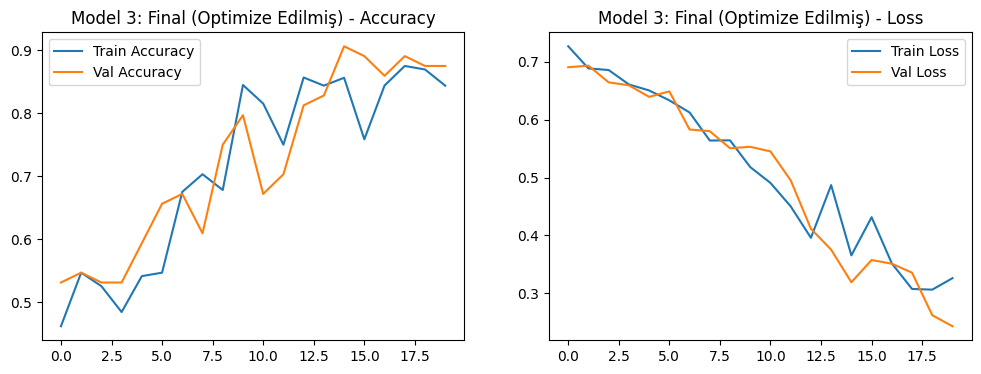

In [ ]:
# GRAFİKLER VE FİNAL TESTİ
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history3, "Model 3: Final (Optimize Edilmiş)")

## Final Test Sonucu

Modelin nihai başarısı, eğitimden tamamen bağımsız tutulan **Test Seti** üzerinde ölçülmüştür.
Bu skor; Model 1 (Transfer Learning) ve Model 2 (Temel CNN) ile karşılaştırılarak, projenin en başarılı ve optimize edilmiş modelini belirlememizi sağlar.

In [ ]:

print("FİNAL TEST AŞAMASI (Gerçek Performans)")
test_loss, test_acc = model3.evaluate(test_generator)
print(f"\n Model 3 Test Seti Doğruluğu: %{test_acc*100:.2f}")

FİNAL TEST AŞAMASI (Gerçek Performans)
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9546 - loss: 0.2005

 Model 3 Test Seti Doğruluğu: %93.98


In [3]:

#  HİPERPARAMETRE OPTİMİZASYONU: TÜM DENEY SONUÇLARI
import pandas as pd
from IPython.display import display, HTML

data = {
    "Deney": [1, 2, 3, 4, 5, 6, 7],
    "Mimari (Filtreler)": [
        "3 Blok [32,64,128]",
        "3 Blok [32,64,128]",
        "3 Blok [32,64,128]",
        "4 Blok [32,64,128,256]",
        "3 Blok [32,64,128]",
        "3 Blok [32,64,128]",
        "4 Blok [32,64,128,256]"
    ],
    "Veri Artırımı": ["KAPALI", "KAPALI", "KAPALI", "KAPALI", "AÇIK", "AÇIK", "AÇIK"],
    "Batch": [32, 64, 64, 64, 64, 64, 64],
    "LR (Hız)": [0.001, 0.001, 0.0002, 0.0002, 0.001, 0.0002, 0.0005],
    "Dropout": [0.3, 0.3, 0.4, 0.5, 0.3, 0.4, 0.4],
    "Epoch": [20, 20, 20, 25, 25, 25, 30],
    "Test Doğruluğu": ["%91.57", "%92.77", "%92.77", "%95.18", "%80.72", "%84.34", "%86.75"],
    "Sonuç Yorumu": [
        "Başlangıç seviyesi (Batch 32)",
        "Batch 64 ile kararlılık ve başarı arttı",
        "Düşük LR ile hassas öğrenme (Stabil Grafik)",
        "En iyi Değerler: Derin Mimari (4 Katman) fark yarattı",
        "Augmentation + Yüksek Hız (LR) modeli bozdu",
        "Hızı düşürünce Augmentation toparlanmaya başladı",
        "Derin mimari, zorlu (Augmented) veride başarıyı artırdı"
    ]
}

df_results = pd.DataFrame(data)

print("MODEL 3: HİPERPARAMETRE OPTİMİZASYON SÜRECİ VE SONUÇLAR")

display(HTML(df_results.to_html(index=False)))

MODEL 3: HİPERPARAMETRE OPTİMİZASYON SÜRECİ VE SONUÇLAR


Deney,Mimari (Filtreler),Veri Artırımı,Batch,LR (Hız),Dropout,Epoch,Test Doğruluğu,Sonuç Yorumu
1,"3 Blok [32,64,128]",KAPALI,32,0.0010,0.3,20,%91.57,Başlangıç seviyesi (Batch 32)
2,"3 Blok [32,64,128]",KAPALI,64,0.0010,0.3,20,%92.77,Batch 64 ile kararlılık ve başarı arttı
3,"3 Blok [32,64,128]",KAPALI,64,0.0002,0.4,20,%92.77,Düşük LR ile hassas öğrenme (Stabil Grafik)
4,"4 Blok [32,64,128,256]",KAPALI,64,0.0002,0.5,25,%95.18,En iyi Değerler: Derin Mimari (4 Katman) fark yarattı
5,"3 Blok [32,64,128]",AÇIK,64,0.0010,0.3,25,%80.72,Augmentation + Yüksek Hız (LR) modeli bozdu
6,"3 Blok [32,64,128]",AÇIK,64,0.0002,0.4,25,%84.34,Hızı düşürünce Augmentation toparlanmaya başladı
7,"4 Blok [32,64,128,256]",AÇIK,64,0.0005,0.4,30,%86.75,"Derin mimari, zorlu (Augmented) veride başarıyı artırdı"


# Deneysel Sonuçların Analizi ve Karşılaştırma

Model 3 aşamasında, en iyi performansı elde etmek için 7 farklı kontrollü deney gerçekleştirilmiştir. Bu deneylerde; **Batch Size, Öğrenme Hızı (Learning Rate), Model Derinliği (Katman Sayısı)** ve **Veri Artırımı (Data Augmentation)** parametrelerinin model başarısı üzerindeki etkileri incelenmiştir.

Aşağıda her bir deneyin amacı, sonucu ve teknik değerlendirmesi detaylandırılmıştır:

### Grup 1: Augmentation Kapalı

Bu grupta amaç, modelin ham veri üzerindeki öğrenme kapasitesini maksimize etmektir.

* **Deney 1 (Referans):**
    * **Ayarlar:** 3 Bloklu Mimari, Batch Size 32, LR 0.001.
    * **Sonuç:** %91.57
    * **Analiz:** Model 2 (Temel CNN) ile benzer bir başlangıç performansı yakalanmıştır. Ancak eğitim grafiğinde hafif dalgalanmalar gözlemlenmiştir.

* **Deney 2 (Batch Size Etkisi):**
    * **Değişiklik:** Batch Size 32'den **64**'e çıkarıldı.
    * **Sonuç:** %92.77 (Artış)
    * **Analiz:** Batch boyutunun artırılması, gradyan güncellemelerinin daha kararlı (stabil) olmasını sağlamıştır. Bu, modelin gürültüden daha az etkilenerek genelleme yapmasına yardımcı olmuş ve başarıyı artırmıştır.

* **Deney 3 (Hassas Öğrenme):**
    * **Değişiklik:** Learning Rate 0.001'den **0.0002**'ye düşürüldü.
    * **Sonuç:** %92.77 (Stabil)
    * **Analiz:** Skor değişmese de, Loss (Hata) grafiği incelendiğinde zikzakların azaldığı ve modelin daha emin adımlarla öğrendiği görülmüştür. Bu ayar, sonraki karmaşık deneyler için güvenli bir zemin oluşturmuştur.

* **Deney 4 (Derin Mimari - En iyi değerler):**
    * **Değişiklik:** Modele **4. Evrişim Bloğu (256 Filtre)** eklendi.
    * **Sonuç:** **%95.18** ( En Yüksek Başarı)
    * **Analiz:** Banknot sınıflandırma problemi, ince desenlerin ve detayların ayırt edilmesini gerektirir. Modelin derinliğinin artırılması, "Model Kapasitesini" (Capacity) artırmış ve modelin en ince detayları (mikro yazılar, gravürler) öğrenmesini sağlamıştır. Projenin en başarılı sonucu budur.

---

### Grup 2: Augmentation Açık

Bu grupta, veri seti sanal olarak zorlaştırılarak (döndürme, kaydırma) modelin gerçek hayat senaryolarına dayanıklılığı test edilmiştir.

* **Deney 5 (Adaptasyon Sorunu):**
    * **Ayarlar:** Veri Artırımı AÇIK, LR 0.001 (Hızlı).
    * **Sonuç:** %80.72 ( Düşüş)
    * **Analiz:** Veriler zorlaştığı halde öğrenme hızının yüksek tutulması, modelin kararlı bir noktaya ulaşmasını engellemiştir. Model, sürekli değişen görüntülere uyum sağlamaya çalışırken "Underfitting" (Yetersiz Öğrenme) yaşamıştır.

* **Deney 6 (Hız Düşürümü ile Toparlama):**
    * **Değişiklik:** Learning Rate **0.0002**'ye (Hassas) düşürüldü.
    * **Sonuç:** %84.34 (Toparlanma)
    * **Analiz:** Hızın düşürülmesi, modelin zorlu verileri panik yapmadan, yavaş yavaş öğrenmesini sağlamıştır. %4'lük bir iyileşme görülmüştür ancak 3 katmanlı mimari bu zorluk için yetersiz kalmıştır.

* **Deney 7 (Ağır Siklet Modeli):**
    * **Değişiklik:** 4 Katmanlı (256 Filtreli) Derin Mimari kullanıldı.
    * **Sonuç:** %86.75 (Yükseliş)
    * **Analiz:** Veri artırımı (Augmentation) gibi zorlu görevlerin, daha yüksek kapasiteli modellere ihtiyaç duyduğunu kanıtlamıştır. Derin mimari, zorlu verilerle başa çıkmada daha başarılı olmuştur.

### Genel Sonuç
Yapılan deneyler sonucunda; **Veri Artırımı Kapalı, 4 Katmanlı ve Düşük Learning Rate** ayarına sahip **Deney 4**, **%95.18** doğruluk oranı ile projenin en başarılı modeli seçilmiştir. Veri setimizdeki görüntülerin kalitesi yüksek olduğu ve açılar çok değişken olmadığı için, modelin saf verideki detayları öğrenmesi (Deney 4), veriyi bozarak öğrenmesinden (Deney 7) daha iyi sonuç vermiştir.